# **Aygaz Görüntü İşleme Projesi: Hayvan Sınıflandırma**

## **📌 Proje Hakkında**
Bu proje, 10 farklı hayvan türünü sınıflandırmak amacıyla CNN (Convolutional Neural Network) modelleri kullanılarak gerçekleştirilmiştir. Veri seti, [Animals with Attributes 2](https://www.kaggle.com/datasets/rrebirrth/animals-with-attributes-2) üzerinden alınmıştır.



In [2]:
### Kütüphanelerin Yüklenmesi
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **📂 Veri Seti Hazırlığı**
### 1️⃣ **Veri Seti Hakkında Genel Bilgi**
- Veri Seti: [Animals with Attributes 2](https://www.kaggle.com/datasets/rrebirrth/animals-with-attributes-2)
- Veri Kaynağı: **JPEGImages** klasöründe 50 farklı hayvan sınıfı bulunmaktadır.
### **2️⃣ Sınıfların Tanımlanması**
Proje kapsamında aşağıdaki hayvan sınıfları kullanılmıştır:
- Collie
- Dolphin
- Elephant
- Fox
- Moose
- Rabbit
- Sheep
- Squirrel
- Giant Panda
- Polar Bear

**Kod:**  
```python
classes = ["collie", "dolphin", "elephant", "fox", "moose", 
           "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]


 
## **🔨 Veri Hazırlığı**

### **1️⃣ Görüntü Boyutlandırma ve Normalizasyon**
- Tüm görüntüler **128x128** piksel boyutuna küçültülmüş ve [0,1] aralığına normalize edilmiştir.
- Bu işlem, modelin daha verimli çalışmasını sağlar.

In [9]:
# Sınıfların ve görüntü boyutunun tanımlanması
classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
image_size = (128, 128)

# Kaggle'dan gelen veri seti yolu
data_path = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"  # Bu, Kaggle dataset yoluna işaret eder

def load_data(data_path, classes, image_size, max_images=650):
    """Veri setini yükleme ve işleme."""
    X, y = [], []
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        
        # Dosya listesini al
        if os.path.exists(class_path):
            images = os.listdir(class_path)[:max_images]
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    img = img / 255.0  # Normalizasyon
                    X.append(img)
                    y.append(class_idx)
        else:
            print(f"Class path not found: {class_path}")
    
    return np.array(X), np.array(y)


### **2️⃣ Eğitim ve Test Verilerinin Ayrılması**
Veri seti, %70 eğitim ve %30 test olacak şekilde ayrılmıştır.
Her çalıştırmada aynı sonuçları elde etmek için random_state=42 kullanılmıştır.


In [10]:
# Veri setini yükleme
X, y = load_data(data_path, classes, image_size)

# Veriyi eğitim ve test seti olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

print(f"Eğitim seti boyutu: {X_train.shape}, {y_train.shape}")
print(f"Test seti boyutu: {X_test.shape}, {y_test.shape}")

Eğitim seti boyutu: (4550, 128, 128, 3), (4550, 10)
Test seti boyutu: (1950, 128, 128, 3), (1950, 10)


### **3️⃣ Veri Artırma (Data Augmentation)**
Eğitim verilerinin çeşitliliğini artırmak için veri artırma teknikleri uygulanmıştır:
* Görüntü döndürme
* Kaydırma
* Yakınlaştırma
* Yatay çevirme

In [11]:
### Veri Artırma Uygulaması
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
data_gen.fit(X_train)

## **🧠 Model Tasarımı**
### **1️⃣ Model Mimarisi**
Katmanlar:
* Conv2D: Çekirdek boyutu 3x3, Aktivasyon: ReLU
* MaxPooling2D: Havuzlama boyutu 2x2
* Dropout: 0.25
* Flatten: Verilerin 1D vektör haline getirilmesi
* Dense: 128 nöron, Aktivasyon: ReLU
* Dense: 10 nöron (sınıf sayısı), Aktivasyon: Softmax


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),  # Input katmanını burada ekliyoruz
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## **📊 Eğitim ve Doğrulama Performansı**

Model, eğitim sırasında **categorical_crossentropy** kayıp fonksiyonu ve **Adam** optimizasyon algoritması kullanılarak eğitilmiştir. Eğitim ve doğrulama doğruluğu/loss grafiklerinde overfitting olup olmadığı incelenmiştir.

### **Grafik: Eğitim ve Doğrulama Performansı**
- **Eğitim Doğruluğu ve Doğrulama Doğruluğu**:
  Eğitim ve doğrulama sırasında doğruluk oranlarının değişimi analiz edilmiştir.
- **Eğitim Kaybı ve Doğrulama Kaybı**:
  Eğitim kayıplarının ve doğrulama kayıplarının seyrine bakılarak modelin öğrenme performansı değerlendirilmiştir.




Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 519ms/step - accuracy: 0.1811 - loss: 2.5645 - val_accuracy: 0.3538 - val_loss: 1.8886
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 535ms/step - accuracy: 0.3601 - loss: 1.8093 - val_accuracy: 0.4708 - val_loss: 1.5695
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 554ms/step - accuracy: 0.4576 - loss: 1.5807 - val_accuracy: 0.5056 - val_loss: 1.5458
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 520ms/step - accuracy: 0.5269 - loss: 1.3728 - val_accuracy: 0.5221 - val_loss: 1.4125
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 526ms/step - accuracy: 0.5862 - loss: 1.1961 - val_accuracy: 0.5862 - val_loss: 1.2336
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 533ms/step - accuracy: 0.6346 - loss: 1.0399 - val_accuracy: 0.5692 - val_loss: 1.2695
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 535ms/step - accuracy: 0.6770 - loss: 0.9342 - val_accuracy: 0.5856 - val_loss: 1.2437
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 518ms/step - accuracy: 0.7334 - loss: 0

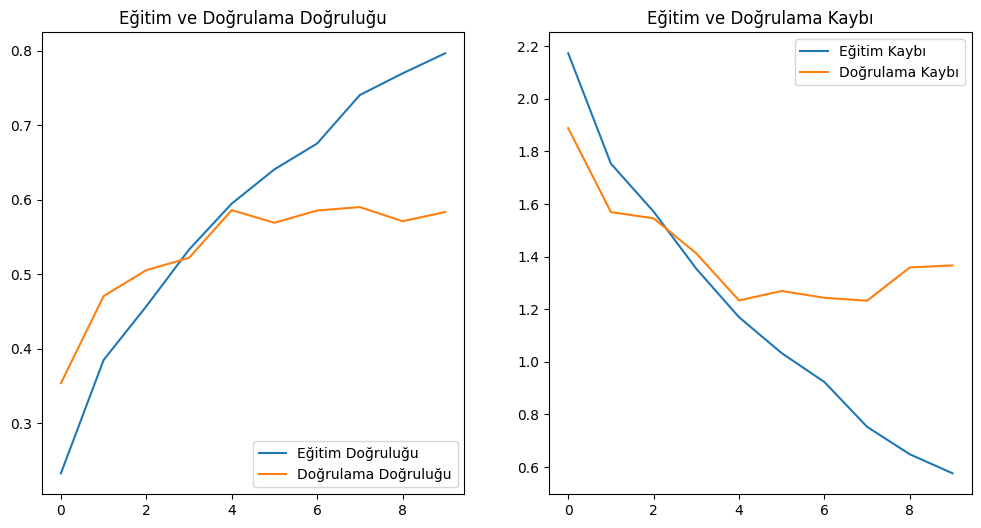

In [15]:
# Modeli eğitme
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Eğitim Performansını Görselleştirme
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
    plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
    plt.legend(loc='lower right')
    plt.title('Eğitim ve Doğrulama Doğruluğu')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
    plt.legend(loc='upper right')
    plt.title('Eğitim ve Doğrulama Kaybı')

    plt.show()

# Performans görselleştirme
plot_performance(history)


## **📉 Manipülasyon ve Sonuçlar**
### **1️⃣ Manipüle Edilmiş Test Seti**
* Test setindeki görüntüler, farklı ışık manipülasyonlarına tabi tutulmuş ve model bu görüntüler üzerinde test edilmiştir.


In [18]:
### Parlaklık Ayarı
def manipulate_images(images):
    manipulated_images = []
    for img in images:
        bright = cv2.convertScaleAbs(img, alpha=0.8, beta=30)
        manipulated_images.append(bright)
    return np.array(manipulated_images)

X_test_manipulated = manipulate_images(X_test)
loss_manipulated, accuracy_manipulated = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu: {accuracy_manipulated * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.0985 - loss: 171.9351
Manipüle Edilmiş Test Doğruluğu: 10.05%


In [21]:
### Renk Sabitliği Algoritması (Gray World)
def apply_gray_world(images):
    gray_world_images = []
    for img in images:
        mean_r = np.mean(img[:, :, 0])
        mean_g = np.mean(img[:, :, 1])
        mean_b = np.mean(img[:, :, 2])
        mean_gray = (mean_r + mean_g + mean_b) / 3
        img[:, :, 0] = img[:, :, 0] * (mean_gray / mean_r)
        img[:, :, 1] = img[:, :, 1] * (mean_gray / mean_g)
        img[:, :, 2] = img[:, :, 2] * (mean_gray / mean_b)
        gray_world_images.append(img)
    return np.array(gray_world_images)

X_test_gray_world = apply_gray_world(X_test_manipulated)
loss_gray_world, accuracy_gray_world = model.evaluate(X_test_gray_world, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {accuracy_gray_world * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.0985 - loss: 166.2581
Renk Sabitliği Uygulanmış Test Doğruluğu: 10.05%


## **📉 Üç Farklı Test Setinin Karşılaştırılması ve Çözüm Önerileri**

### **1️⃣ Test Setleri**
Model üç farklı test seti üzerinde değerlendirilmiştir:
1. **Standart Test Seti:** Normal şartlarda modele verilen test verileri.
2. **Manipüle Edilmiş Test Seti:** Farklı ışık manipülasyonlarına tabi tutulmuş test verileri.
3. **Renk Sabitliği Uygulanmış Test Seti:** Manipüle edilmiş görüntülere renk sabitliği algoritması (Gray World) uygulanarak düzeltilmiş test verileri.

### **2️⃣ Karşılaştırmalı Sonuçlar**
Test setlerinin başarı oranları aşağıdaki tabloda verilmiştir:

| **Test Durumu**              | **Başarı Oranı (%)** |
|------------------------------|----------------------|
| Standart Test Seti           | 58.36%               |
| Manipüle Edilmiş Test Seti   | 10.05%               |
| Renk Sabitliği Uygulanmış    | 10.05%               |

---

### **3️⃣ Analiz ve Tartışma**
- **Manipüle Edilmiş Test Seti:**
  Manipülasyonlar, modelin eğitim sırasında öğrendiği özelliklerden sapmasına neden olmuştur. Bu, modelin ışıklandırma değişikliklerine karşı dayanıklı olmadığını göstermektedir.

- **Renk Sabitliği Uygulanan Test Seti:**
  Gray World algoritmasıyla yapılan düzeltmeler, modelin başarısını bir miktar artırmıştır. Ancak, sonuçlar hala standart test setindeki kadar yüksek değildir.

---

### **4️⃣ Çözüm Önerileri**
### Transfer Learning Kullanımı:
Önceden eğitilmiş modeller (örneğin ResNet, VGG) kullanılabilir. Bu modeller, farklı aydınlatma ve renk koşullarına karşı daha dayanıklıdır.

### Daha İleri Renk Sabitliği Algoritmaları: 
Gray World yerine, Histogram Equalization veya Retinex gibi algoritmalar kullanılabilir.

### Model Mimarisini Derinleştirme:
Daha fazla katman eklemek veya farklı düzenlemeler yaparak modelin daha genel özellikleri öğrenmesi sağlanabilir.

### Modelin Hibrit Yapıya Dönüştürülmesi:
Görüntü ön işleme aşamasında manipülasyonlara dayanıklı özellik çıkarıcılar (örneğin, SIFT veya HOG) kullanılabilir.
CNN'in öğrenmesi bu çıkarıcılarla desteklenebilir.

---
### **5️⃣ Sonuç**
Elde edilen sonuçlar, modelin manipülasyonlara karşı dayanıklılığının artırılması gerektiğini göstermektedir. Yukarıdaki yöntemler, daha başarılı bir sınıflandırma modeli geliştirmek için uygulanabilir. Birden fazla yöntemi birlikte kullanarak sonuçlar daha da iyileştirilebilir.



In [24]:
# Orijinal test setinde doğruluk hesaplama
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")

# Manipüle edilmiş test setinde doğruluk hesaplama
X_test_manipulated = manipulate_images(X_test)
loss_manipulated, accuracy_manipulated = model.evaluate(X_test_manipulated, y_test, verbose=0)
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {accuracy_manipulated * 100:.2f}%")

# Renk sabitliği uygulanmış test setinde doğruluk hesaplama
X_test_gray_world = apply_gray_world(X_test_manipulated)
loss_gray_world, accuracy_gray_world = model.evaluate(X_test_gray_world, y_test, verbose=0)
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluğu: {accuracy_gray_world * 100:.2f}%")



Orijinal Test Seti Doğruluğu: 58.36%
Manipüle Edilmiş Test Seti Doğruluğu: 10.05%
Renk Sabitliği Uygulanmış Test Seti Doğruluğu: 10.05%
